In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import lightgbm
import xgboost

from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 

# Plotly 
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.offline import init_notebook_mode,iplot
import cufflinks as cf
init_notebook_mode(connected=True)

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize

from collections import defaultdict

from lazypredict.Supervised import LazyClassifier

import imblearn

In [2]:
df = pd.read_csv('../data/processed/tanishq_data_clean_labelled.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
df['clean_tweet_token'] = df['clean_tweet_segmented'].apply(lemmatizer.lemmatize).apply(tokenizer.tokenize)
df['clean_tweet_token'] = df['clean_tweet_token'].str.join(' ')
df = df[['clean_tweet_token', 'sentiment']]
df.dropna(inplace=True)
df = df[df['sentiment'].isin([0.0, 4.0])]
df['sentiment'] = df['sentiment'].replace({4.0: 1})

In [3]:
count_vec = CountVectorizer()
X_count_vec = count_vec.fit_transform(df['clean_tweet_token'])
y = df['sentiment'].values 
X_train, X_test, y_train, y_test = train_test_split(X_count_vec, y, test_size=0.25)

In [4]:
def process_smote(X=None, y=None, sampling=None):
    X, y = sampling.fit_resample(X, y)
    pca = PCA(n_components=2).fit_transform(X.toarray())
    df = pd.DataFrame(pca)
    df.columns = ['X1', 'X2']
    df['labels'] = y
    return X, y, df

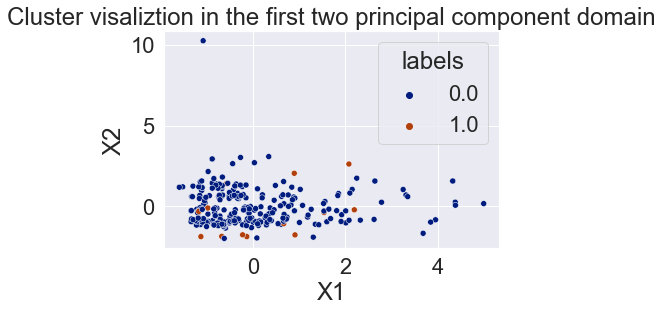

In [6]:
sns.set(font_scale=2)
pca = PCA(n_components=2).fit_transform(X_train.toarray())
df_prim = pd.DataFrame(pca)
df_prim.columns = ['X1', 'X2']
df_prim['labels'] = y_train
ax = sns.scatterplot(x='X1', y='X2', hue='labels', 
    data=df_prim, palette="dark")
ax.set(title="Cluster visaliztion in the first two principal component domain")
plt.savefig('../images/PCA_before_smoteenn.png')

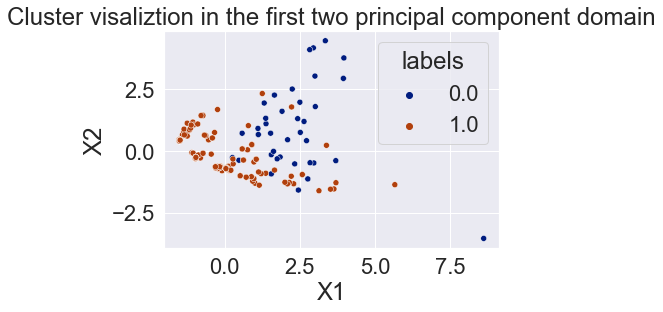

In [7]:
# SMOTEENN
sampling = imblearn.combine.SMOTEENN()
X_smoteenn, y_smoteenn, df_smoteenn = process_smote(X=X_train, y=y_train, sampling=sampling) 
sns.set(font_scale=2)
ax = sns.scatterplot(x='X1', y='X2', hue='labels', 
    data=df_smoteenn, palette="dark")
ax.set(title="Cluster visaliztion in the first two principal component domain")
plt.savefig('../images/PCA_after_smoteenn.png')


In [8]:
def process_lazypredict(X_train=None, y_train=None, X_test=None, y_test=None):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models

In [9]:
X_test

<92x1657 sparse matrix of type '<class 'numpy.int64'>'
	with 2009 stored elements in Compressed Sparse Row format>

In [10]:
models_smoteenn = process_lazypredict(X_train=X_smoteenn.toarray(), 
    y_train=y_smoteenn, X_test=X_test.toarray(), y_test=y_test)

100%|██████████| 30/30 [00:03<00:00,  9.20it/s]


In [11]:
models_smoteenn

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.63,0.81,0.81,0.74,0.20
LinearDiscriminantAnalysis,0.60,0.79,0.79,0.71,0.15
Perceptron,0.59,0.78,0.78,0.70,0.05
AdaBoostClassifier,0.70,0.72,0.72,0.79,0.26
SGDClassifier,0.40,0.69,0.69,0.53,0.06
ExtraTreesClassifier,0.59,0.66,0.66,0.70,0.15
RandomForestClassifier,0.54,0.64,0.64,0.67,0.17
DecisionTreeClassifier,0.73,0.62,0.62,0.81,0.05
XGBClassifier,0.66,0.59,0.59,0.76,0.33


In [12]:
fig = px.bar(models_smoteenn.reset_index(), x='Model', y='ROC AUC', color='Model', color_discrete_sequence=px.colors.qualitative.Dark24_r)
fig.show()

Based on the performance of different models with default hyperparameters, we decided to perform hyperparameter optimization of AdaBoostClassifier, DecisionTreeClassifier, LGBMClassifier, and XGBClassifier.

Hyperparametr to optimize:

AdaBoostClassifier (GridSearchCV): learning_rate (1), n_estimators (50), base_estimator (DecisionTreeClassifier(max_depth=1))

DecisionTreeClassifier (GridSearchCV): max_depth (None), min_samples_split (2), max_features (None) 

XGBClassifier: n_estimators, max_depth, reg_alpha, reg_lambda, eta, gamma, subsample, colsample_bytree

<!---
LightGBM: num_boost_round, num_leaves, max_depth, lambda_l2, lambda_l1, min_child_samples, min_data_in_leaf
--->

In [13]:
X_train=X_smoteenn.toarray()
y_train=y_smoteenn
X_test=X_test.toarray()
y_test=y_test

In [14]:
# AdaBoostClassifier

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score)}

param_grid = {
    'learning_rate': np.arange(0, 1.1, 0.2),
    'n_estimators': np.arange(0, 205, 50),
    #'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

ada = AdaBoostClassifier(random_state=42)

gs_ada = GridSearchCV(estimator=ada, 
                      param_grid=param_grid,
                      scoring=scoring,
                      refit='AUC',
                      return_train_score=True,
                      cv=3)
gs_ada.fit(X_train, y_train)
y_pred = gs_ada.predict(X_test)

print('Accuracy for optimized ada: {}'.format(accuracy_score(y_test, y_pred)))
print('F1 score for optimized ada: {}'.format(f1_score(y_test, y_pred)))
print('ROC AUC for optimized ada: {}'.format(roc_auc_score(y_test, y_pred)))


Accuracy for optimized ada: 0.6739130434782609
F1 score for optimized ada: 0.16666666666666666
ROC AUC for optimized ada: 0.7102272727272727


In [15]:
ada_results = gs_ada.cv_results_
gs_ada.best_params_

{'learning_rate': 0.2, 'n_estimators': 150}

In [16]:
gs_ada_df = pd.DataFrame()
for k in param_grid:
    gs_ada_df[k] = ada_results['param_' + k]

for k in ['Accuracy', 'Precision', 'AUC', 'Recall']:
    gs_ada_df['mean_train_' + k] = ada_results['mean_train_' + k]
    gs_ada_df['std_train_' + k] = ada_results['std_train_' + k]
    gs_ada_df['mean_test_' + k] = ada_results['mean_test_' + k]
    gs_ada_df['std_test_' + k] = ada_results['std_test_' + k]


In [17]:
#gs_ada_df['max_depth'] = gs_ada_df['base_estimator'].apply(lambda x: x.max_depth)

In [18]:
gs_ada_df = gs_ada_df[gs_ada_df['learning_rate'] == 0.8]
#gs_ada_df = gs_ada_df[gs_ada_df['max_depth'] == 2]
gs_ada_df

,learning_rate,n_estimators,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy,mean_train_Precision,std_train_Precision,mean_test_Precision,std_test_Precision,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC,mean_train_Recall,std_train_Recall,mean_test_Recall,std_test_Recall
20,0.8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.8,50,1.00,0.00,0.97,0.02,1.00,0.00,0.97,0.03,1.00,0.00,0.99,0.01,1.00,0.00,0.99,0.01
22,0.8,100,1.00,0.00,0.97,0.02,1.00,0.00,0.98,0.02,1.00,0.00,0.99,0.01,1.00,0.00,0.99,0.01
23,0.8,150,1.00,0.00,0.97,0.01,1.00,0.00,0.97,0.01,1.00,0.00,0.99,0.01,1.00,0.00,0.99,0.01
24,0.8,200,1.00,0.00,0.98,0.02,1.00,0.00,0.98,0.01,1.00,0.00,1.00,0.01,1.00,0.00,0.99,0.01


In [19]:
fig = go.Figure([
    go.Scatter(
        name='test_auc',
        x=gs_ada_df['n_estimators'],
        y=gs_ada_df['mean_test_AUC'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        x=gs_ada_df['n_estimators'],
        y=gs_ada_df['mean_test_AUC']+gs_ada_df['std_test_AUC'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        x=gs_ada_df['n_estimators'],
        y=gs_ada_df['mean_test_AUC']-gs_ada_df['std_test_AUC'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='Score',
    title='GridSearchCV for n_estimators',
    hovermode="x"
)
fig.show()

In [20]:
# DecisionTreeClassifier

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score)}

param_grid = {
    'max_depth': [None, 2, 4, 6, 8],
    'min_samples_split': [2, 10, 25, 50],
    'max_features': [None, 'log2', 'sqrt']
}

dtc = DecisionTreeClassifier(random_state=42)

gs_dtc = GridSearchCV(estimator=dtc, 
                      param_grid=param_grid,
                      scoring=scoring,
                      refit='AUC',
                      return_train_score=True,
                      cv=3)
gs_dtc.fit(X_train, y_train)
y_pred = gs_dtc.predict(X_test)

print('Accuracy for optimized ada: {}'.format(accuracy_score(y_test, y_pred)))
#print('F1 score for optimized ada: {}'.format(f1_score(y_test, y_pred)))
print('ROC AUC for optimized ada: {}'.format(roc_auc_score(y_test, y_pred)))

Accuracy for optimized ada: 0.717391304347826
ROC AUC for optimized ada: 0.6136363636363635


In [21]:
def xgb_classifier(n_estimators, max_depth, reg_alpha,
                   reg_lambda, eta, subsample, colsample_bytree,
                   gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "subsample" : subsample,
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "colsmaple_bytree": colsample_bytree}
    train_data = xgboost.DMatrix(X_train, y_train)
    cv_result = xgboost.cv(params,
                       train_data,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [22]:
xgbBO = BayesianOptimization(f=xgb_classifier, pbounds={"n_estimators": (10, 100),
                                                'max_depth': (2, 40),
                                                'reg_alpha': (0.0, 1.0),
                                                'reg_lambda': (0.0, 1.0),
                                                'subsample': (0.0, 1.0),
                                                'colsample_bytree': (0.0, 1.0),
                                                "gamma": (0, 10),
                                                "eta": (0.0, 1.0)
                                                })

xgbBO.maximize(n_iter=20, init_points=2)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9665   |  0.5638   |  0.6463   |  8.344    |  14.55    |  88.39    |  0.9797   |  0.4085   |  0.6138   |
|  2        |  0.9585   |  0.1884   |  0.3584   |  7.901    |  5.775    |  83.22    |  0.9749   |  0.9877   |  0.7194   |
|  3        |  0.983    |  0.6432   |  0.4132   |  3.738    |  32.59    |  17.84    |  0.7745   |  0.9536   |  0.968    |
|  4        |  0.9847   |  0.4391   |  0.7482   |  3.675    |  33.37    |  17.39    |  0.2637   |  0.6244   |  0.9807   |
|  5        |  0.9787   |  0.0      |  1.0      |  10.0     |  40.0     |  10.0     |  0.0      |  0.0      |  1.0      |
|  6        |  0.0      |  0.0      |  1.0      |  0.0      |  40.0     |  24.59    |  0.0      |  0.0      |  0.0      |
|  7        |  0.9819   

In [23]:
xgbBO.max

{'target': 0.9887796666666667,
 'params': {'colsample_bytree': 0.7686291153387972,
  'eta': 0.5727806533101856,
  'gamma': 0.08229630682380029,
  'max_depth': 9.15351941532545,
  'n_estimators': 21.475042347352797,
  'reg_alpha': 0.7686628238361989,
  'reg_lambda': 0.18909822039363633,
  'subsample': 0.8564646340988931}}

In [24]:
train_data = xgboost.DMatrix(X_train, y_train)
params = xgbBO.max['params']
params['objective'] = 'binary:logistic'
params['max_depth'] = 10
params['n_estimators'] = 80
xgb_opt = xgboost.train(dtrain=train_data,
                          params=params,
                          #early_stopping_rounds=100,
                          num_boost_round=1000)

In [25]:
y_pred = xgb_opt.predict(xgboost.DMatrix(X_test))

#print('Accuracy for optimized ada: {}'.format(accuracy_score(y_test, y_pred)))
#print('F1 score for optimized ada: {}'.format(f1_score(y_test, y_pred)))
print('ROC AUC for optimized ada: {}'.format(roc_auc_score(y_test, y_pred)))

ROC AUC for optimized ada: 0.7897727272727272
